# Week 7: Issues and bias in NLP
This notebook accompanies the week 7 lecture.  This week focuses on examples of how NLP models can be subject to unexpected bias/unwanted learning and potential methods for addressing these issues.

In [268]:
%matplotlib inline
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
import pickle

required = {'spacy', 'transformers'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import json
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import transformers
# this will set the device on which to train
device = torch.device("cpu")
# if using collab, set your runtime to use GPU and use the line below
#device = torch.device("cuda:0")

### Learning from group information
In this example, we'll show how removing "group" information from data can hurt the performance of the model, but that including it might lead to bias in favor of one group versus another.  We'll also show some potential ways to include group information, but account for potential bias.

In [40]:
# read in our reviews dataset
# you will need to change this to where ever the file is stored
data_location = '../data/assignment_1_reviews.pkl'
with open(data_location, 'rb') as f:
    all_text = pickle.load(f)
neg, pos = all_text.values()
# join all reviews
all_reviews = np.array(neg+pos)
# make into a dataframe, a bit easier to manipulate
review_df = pd.DataFrame(all_reviews, columns=['review_text'])
review_df['is_positive'] =  [0]*len(neg) + [1]*len(pos)

Let's make up two groups.  Let's say there's a set of "picky" reviewers for whom 90% of their reviews are negative and "nice" reviewers who are about equally likely to give a positive review as a negative review.

In [41]:
# 1000 of each
group_size = 1000
group_neg_chance = {'picky': 0.9, 
                    'nice': 0.5}
group_data = {}
for g in group_neg_chance:
    neg_size = int(group_size*group_neg_chance[g])
    neg_data = review_df[review_df.is_positive==0].sample(neg_size)
    pos_data = review_df[review_df.is_positive==1].sample(group_size-neg_size)
    group_data[g] = pd.concat([neg_data, pos_data])
    
# merge together for model
model_data = pd.concat(group_data.values())
# add in group indicator
model_data['is_nice'] = [0]*group_size + [1]*group_size
# quick check
model_data.groupby('is_nice')['is_positive'].mean()


is_nice
0    0.1
1    0.5
Name: is_positive, dtype: float64

In [133]:
# simple: tfidf + svc with and without groups
# train/test split
X_train, X_test, y_train, y_test = train_test_split(model_data[['review_text', 'is_nice']], 
                                                    model_data.is_positive,
                                                   random_state=42)
# fit tfidf
tfidf = TfidfVectorizer(stop_words='english', min_df=0.01)
train_vecs = tfidf.fit_transform(X_train['review_text']).toarray()
# fit model without group
svc_w_group = LinearSVC().fit(
    np.concatenate((train_vecs, X_train[['is_nice']]), axis=1),
    y_train)
# fit model with group
svc_no_group = LinearSVC().fit(train_vecs, y_train)
# predict on test
test_vecs = tfidf.transform(X_test['review_text']).toarray()
pred_w_group = svc_w_group.predict(np.concatenate((test_vecs, X_test[['is_nice']]), axis=1))
pred_no_group = svc_no_group.predict(test_vecs)

print('Performance with group info:', accuracy_score(pred_w_group, y_test))
print('Performance without group info:', accuracy_score(pred_no_group, y_test))
is_nice = X_test['is_nice'].astype(bool)

print('Performance for nice group with group info:', 
      accuracy_score(pred_w_group[is_nice], 
                     y_test[is_nice]))
print('Performance for picky group with group info:', 
      accuracy_score(pred_w_group[~is_nice], 
                     y_test[~is_nice]))
print('Performance for nice group without group info:', 
      accuracy_score(pred_no_group[is_nice], 
                     y_test[is_nice]))
print('Performance for picky group without group info:', 
      accuracy_score(pred_no_group[~is_nice], 
                     y_test[~is_nice].astype(bool)))

Performance with group info: 0.912
Performance without group info: 0.88
Performance for nice group with group info: 0.8765432098765432
Performance for picky group with group info: 0.9455252918287937
Performance for nice group without group info: 0.831275720164609
Performance for picky group without group info: 0.9260700389105059


It generally seems that using group info improves our performance across the board.  But is the model unfairly biased against picky reviewers? One way to look at this might be to examine the confusion matrix (i.e. the number of times each class is correctly/incorrectly classified.  Do these numbers vary by group?

In [137]:
from sklearn.metrics import confusion_matrix
print('Nice group confusion matrix\n',
      confusion_matrix(pred_w_group[is_nice], y_test[is_nice]))
print('Picky group confusion matrix\n',
      confusion_matrix(pred_w_group[~is_nice], y_test[~is_nice]))

Nice group confusion matrix
 [[107  24]
 [  6 106]]
Picky group confusion matrix
 [[229  11]
 [  3  14]]


This suggests that the model wrongly classifies positive reviews as negative 44% (11/25) of the time for picky reviewers, but only 18% (24/130) of the time for nice reviewers.  That's >2x more likely to mis-classify a positive review! Let's see if we can reduce that.

### Exercise: Improve group-wise recall
Think of some methods we might use to reduce the misclassification of positive reviews for the picky group.  Some strategies you might want to consider is the `class_weight` parameter in SVC or ensembling models (e.g. averaging predicted probabilities, fitting a model to the predictions)

In [180]:
# weight classes by inverse frequency in train
class_weight = (1/y_train.value_counts(normalize=True)).to_dict()
svc_balanced = LinearSVC(class_weight=class_weight).fit(
    np.concatenate((train_vecs, X_train[['is_nice']]), axis=1),
    y_train)
# predict on test
test_vecs = tfidf.transform(X_test['review_text']).toarray()
pred_balanced = svc_balanced.predict(np.concatenate((test_vecs, X_test[['is_nice']]), axis=1))
print('Performance with weights:', accuracy_score(pred_balanced, y_test))
print('Nice group confusion matrix\n',
      confusion_matrix(pred_balanced[is_nice], y_test[is_nice]))
print('Picky group confusion matrix\n',
      confusion_matrix(pred_balanced[~is_nice], y_test[~is_nice]))

Performance with weights: 0.908
Nice group confusion matrix
 [[105  22]
 [  8 108]]
Picky group confusion matrix
 [[225   9]
 [  7  16]]


Nice! We've reduced the missclassification rate for positive reviews for picky reviewers and nice reviewers without hurting accuracy much.  What if we tried just fitting separate models here?

In [189]:
# fit model with group
is_nice_train = X_train['is_nice'].astype(bool)
svc_nice = LinearSVC().fit(train_vecs[is_nice_train], y_train[is_nice_train])
svc_picky = LinearSVC().fit(train_vecs[~is_nice_train], y_train[~is_nice_train])
# predict 
test_vecs = tfidf.transform(X_test['review_text']).toarray()
pred_nice = svc_nice.predict(test_vecs[is_nice])
pred_picky = svc_picky.predict(test_vecs[~is_nice])
print('Performance of nice model:', accuracy_score(pred_nice, y_test[is_nice]))
print('Performance of picky model:', accuracy_score(pred_picky, y_test[~is_nice]))
print('Picky group-picky model confusion matrix\n',
      confusion_matrix(pred_picky, y_test[~is_nice]))

Performance of nice model: 0.7942386831275721
Performance of picky model: 0.9105058365758755
Picky group-picky model confusion matrix
 [[232  23]
 [  0   2]]


The accuracy for the picky model is pretty high, but it seems to achieve that by even more bias against picky users.  What if we combine the information here?

In [209]:
pred_nice = svc_nice.predict(test_vecs)
pred_picky = svc_picky.predict(test_vecs)
pred_combined = (pred_nice|pred_picky)
print('Performance of combined predictions:', accuracy_score(pred_combined, y_test))
print('Picky group confusion matrix\n',
      confusion_matrix(pred_combined[~is_nice], y_test[~is_nice]))

Performance of combined predictions: 0.834
Picky group confusion matrix
 [[202   6]
 [ 30  19]]


Another reduction in misclassification! Though this seems to cost some amount of accuracy.  We can also use a proxy for confidence using the distance to the separator in the model.  You might also use probability if using a logistic regression.  This is just one way to try that out

In [234]:
pred_nice = svc_nice.decision_function(test_vecs)
pred_picky = svc_picky.decision_function(test_vecs)
pred_combined = np.mean(np.array([pred_nice, pred_picky]), axis=0)>0
print('Performance of combined predictions:', accuracy_score(pred_combined, y_test))
print('Picky group confusion matrix\n',
      confusion_matrix(pred_combined[~is_nice], y_test[~is_nice]))

Performance of combined predictions: 0.822
Picky group confusion matrix
 [[228  15]
 [  4  10]]


Not really promising here.  A model fit on these two features might be able to learn a smarter combination.

## Identifying bias in word vectors
In this section, we explore a method for identifying bias in word vectors.  In this case we'll be looking at how to evaluate the "gender component" of different vectors and how you might be able to correct for it.  Also, we'll see how that correction may not be totally solving our problem.

In [236]:
nlp = spacy.load('en_core_web_md')

In [258]:
# gendered word pairs
gendered = [('man', 'woman'),
           ('he', 'she'),
           ('father', 'mother'),
           ('son', 'daughter'),
           ('men', 'women'),
           ('boy', 'girl'),
           ('his', 'hers')]

# occupation words (ideally "neutral")
occs = ['nurse', 'homemaker', 'receptionist',
       'boss', 'philosopher', 'maestro']

# get occ vectors
occs_v = np.zeros(shape=(len(occs), 300))
for i, occ in enumerate(occs):
    occs_v[i] = nlp.vocab[occ].vector

In [266]:
# demonstrating occupation bias
# just use he/she
he = nlp.vocab['he'].vector
she = nlp.vocab['she'].vector
occ_he_sim = cosine_similarity(occs_v, he.reshape(1, -1))
occ_she_sim = cosine_similarity(occs_v, she.reshape(1, -1))

Text(0, 0.5, 'similarity to she')

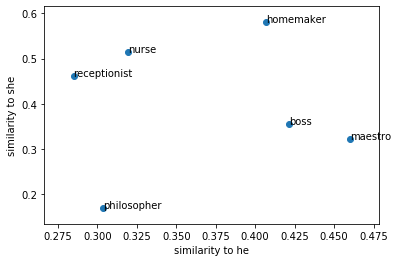

In [280]:
fig, ax = plt.subplots()
ax.scatter(occ_he_sim, occ_she_sim)
for i, occ in enumerate(occs):
    ax.annotate(occ, (occ_he_sim[i], occ_she_sim[i]))
ax.set_xlabel('similarity to he')
ax.set_ylabel('similarity to she')

We can see a simple view of the gender bias embedded in these supposedly neutral occupational terms here.  Another way we might be able to explore this is by creating a "gender" vector and measuring the degree to which a word is gendered by its projection on that vector.  

In [Bolukbasi et. al (2016)](https://arxiv.org/pdf/1607.06520.pdf) they use the first principle component of a decomposition of the difference between gendered words, but we'll just use the average for simplicity.

In [289]:
# gender vector = average of the difference between gendered pairs
gender_vec = np.zeros(shape=(300, ))
for p in gendered:
    gender_vec += nlp.vocab[p[0]].vector - nlp.vocab[p[1]].vector
gender_vec = gender_vec/len(gendered)

In [293]:
# projection = dot product of vectors, normalized
#a = nlp.vocab['test']
for i, occ in enumerate(occs):
    print(occ, occs_v[i].dot(gender_vec)/gender_vec.dot(gender_vec))

nurse -0.6004035111823856
homemaker -0.43700202902639257
receptionist -0.5232524099656529
boss 0.25550318080828693
philosopher 0.46069631122875915
maestro 0.39486994393427016


Note that since we made the vector he-she, the vector is in the "direction" of male-gendered words.  So words that are negative have stronger female associations, positive have stronger male associations.

Check out the projection of "a", which is close to orthogonal to the gender vector (i.e. has no real gender component)

In [297]:
nlp.vocab['a'].vector.dot(gender_vec)/gender_vec.dot(gender_vec)

0.09311277934342956

### Exercise: Explore the "gender" component of various words